In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler






In [5]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
median_age_by_group = df.groupby(['Pclass', 'Sex'])['Age'].transform('median')
df['Age']=df['Age'].fillna(median_age_by_group)
df_upd = df.drop(['Name','Ticket','Cabin'],axis=1)
# df_encoded = pd.get_dummies(df_upd, columns=['Pclass','Sex', 'Embarked'], prefix=['class','Sex', 'Emb'],dtype ='int')
df_encoded = pd.get_dummies(df_upd, columns=['Pclass','Sex'], prefix=['class','Sex'],dtype ='int')
# print(df_encoded.dtypes)
# df_encoded.column

# correlation_matrix = df_encoded.corr()

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()

df_encoded.to_csv('testing.csv', index=False)



columns_scale = ['Age','Fare']
X_train = df_encoded.drop(['PassengerId','Survived','Embarked'],axis=1)

print(X_train.columns)
print(X_train.dtypes)
# # scaler_minmax =MinMaxScaler()
# # X_train[columns_scale] = scaler_minmax.fit_transform(X_train[columns_scale])
scaler_Standard = StandardScaler()
X_train[columns_scale] = scaler_Standard.fit_transform(X_train[columns_scale])
print(X_train.head())
X_train = X_train.values
y_train = df_encoded['Survived'].values
# print(X_train.shape)
# print(y_train.shape)





Index(['Age', 'SibSp', 'Parch', 'Fare', 'class_1', 'class_2', 'class_3',
       'Sex_female', 'Sex_male'],
      dtype='object')
Age           float64
SibSp           int64
Parch           int64
Fare          float64
class_1         int64
class_2         int64
class_3         int64
Sex_female      int64
Sex_male        int64
dtype: object
        Age  SibSp  Parch      Fare  class_1  class_2  class_3  Sex_female  \
0 -0.534891      1      0 -0.502445        0        0        1           0   
1  0.668392      1      0  0.786845        1        0        0           1   
2 -0.234070      0      0 -0.488854        0        0        1           1   
3  0.442776      1      0  0.420730        1        0        0           1   
4  0.442776      0      0 -0.486337        0        0        1           0   

   Sex_male  
0         1  
1         0  
2         0  
3         0  
4         1  


In [6]:
rf_classifier = RandomForestClassifier(random_state=42)

X_train_upd, X_test, y_train_upd, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [None,3,5,7, 10,],
    'min_samples_split': [2,5,7],
    'min_samples_leaf': [2,4]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=kf)

grid_search.fit(X_train_upd, y_train_upd)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy: {:.2f}".format(grid_search.best_score_))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best Accuracy: 0.83


In [7]:
rf_classifier = RandomForestClassifier(n_estimators=50,min_samples_split=5,min_samples_leaf=2,max_depth=10)
X_train_upd, X_test, y_train_upd, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
rf_classifier.fit(X_train_upd, y_train_upd)
training_score = rf_classifier.score(X_test, y_test)
print(training_score)

0.8333333333333334


In [8]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# Define the hyperparameter grid
print(X_train.shape)
print(y_train.shape)
# X_train_upd, X_test, y_train_upd, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150,200],
    'max_depth': [None,3,5,7, 10,],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy: {:.2f}".format(grid_search.best_score_))


(891, 9)
(891,)
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best Accuracy: 0.83


In [9]:
xgb_classifier = xgb.XGBClassifier(learning_rate=0.01,max_depth=5,n_estimators=200, random_state=42,objective='binary:logistic')
xgb_classifier.fit(X_train, y_train)
training_score = xgb_classifier.score(X_train,y_train)
print(training_score)

0.8585858585858586


In [10]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
print(test_df.shape)

submission_df =  test_df[['PassengerId']]

print(submission_df.shape)
print(test_df.head())

median_age_by_group = test_df.groupby(['Pclass', 'Sex'])['Age'].transform('median')
test_df['Age']=test_df['Age'].fillna(median_age_by_group)

print(test_df.shape)
test_df_upd = test_df.drop(['Name','Ticket','Cabin'],axis=1)
# df_encoded = pd.get_dummies(df_upd, columns=['Pclass','Sex', 'Embarked'], prefix=['class','Sex', 'Emb'],dtype ='int')
test_df_encoded = pd.get_dummies(test_df_upd, columns=['Pclass','Sex'], prefix=['class','Sex'],dtype ='int')
# print(df_encoded.dtypes)
# df_encoded.column

print(test_df_encoded.shape)
# correlation_matrix = df_encoded.corr()

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()


columns_scale = ['Age','Fare']
X_test = test_df_encoded.drop(['PassengerId','Embarked'],axis=1)

print(X_test.columns)
print(X_test.dtypes)

scaler_Standard = StandardScaler()
X_test[columns_scale] = scaler_Standard.fit_transform(X_test[columns_scale])
print(X_test.head())
X_test = X_test.values

print(X_test.shape)
# print(y_train.shape)

(418, 11)
(418, 1)
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
(418, 11)
(418, 11)
Index(['Age', 'SibSp', 'Parch', 'Fare', 'class_1', 'class_2', 'class_3',
       'Sex_female', 'Sex_male'],
      dtype='object')
Age      

In [11]:
xgb_classifier = xgb.XGBClassifier(learning_rate=0.01,max_depth=5,n_estimators=200, random_state=42,objective='binary:logistic')
xgb_classifier.fit(X_train, y_train)
training_score = xgb_classifier.score(X_train,y_train)
preds =xgb_classifier.predict(X_test)
print(training_score)




0.8585858585858586


In [12]:
print(preds.shape)

submission_df['Survived']=preds

(418,)


/tmp/ipykernel_47/811025315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['Survived']=preds


In [13]:
submission_df.head()
print(submission_df.shape)

submission_df.to_csv('Submission.csv', index=False)

(418, 2)


In [14]:
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
print(submission.head())

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1


In [15]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy: {:.2f}".format(grid_search.best_score_))

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best Accuracy: 0.83


In [20]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state =42)
dt.fit(X_train,y_train)
trianing_score = dt.score(X_train,y_train)
print(training_score)



0.8585858585858586


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV

lr =LogisticRegression(random_state=42)
lr.fit(X_train,y_train)

training_score = lr.score(X_train, y_train)
print(training_score)


0.8069584736251403


In [28]:

dt_classifier = DecisionTreeClassifier(random_state=42)

X_train_upd, X_test, y_train_upd, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3,5,7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_upd, y_train_upd)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}

training_score = grid_search.score(X_train_upd, y_train_upd)
testing_score =  grid_search.score(X_test,y_test)

print("Training Score:", training_score)
print("testing score;",testing_score)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Accuracy: 0.8177251552795031
Training Score: 0.8277153558052435
testing score; 0.8222222222222222


In [29]:
dt_classifier = DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=1,min_samples_split=5,random_state=42)
dt_classifier.fit(X_train_upd, y_train_upd)
training_score = dt_classifier.score(X_train_upd, y_train_upd)
testing_score =  dt_classifier.score(X_test,y_test)
print("Training Score:", training_score)
print("testing score;",testing_score)

Training Score: 0.8389513108614233
testing score; 0.8222222222222222


In [30]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
training_score = svm_classifier.score(X_train, y_train)
print(training_score)


0.7867564534231201


In [31]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
training_score = svm_classifier.score(X_train, y_train)
print(training_score)

0.7867564534231201


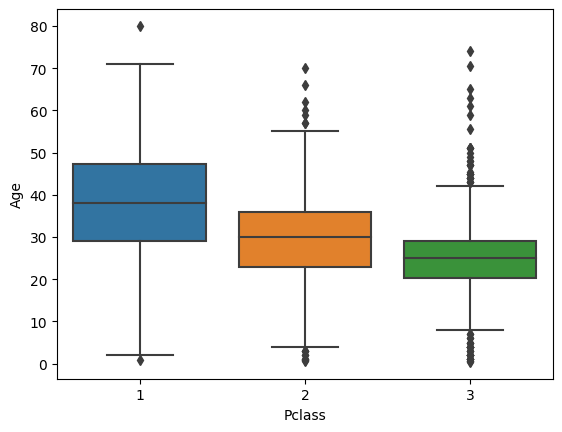

In [32]:
import matplotlib.pyplot as plt
sns.boxplot(x='Pclass',y='Age',data=df)
plt.show()

29.69911764705882
14.526497332334042


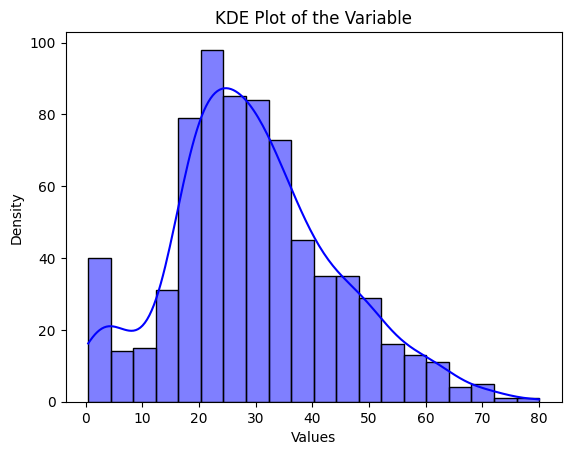

In [33]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
print(df['Age'].mean())
print(df['Age'].std())
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('KDE Plot of the Variable')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()


29.69911764705882
13.002015226002882


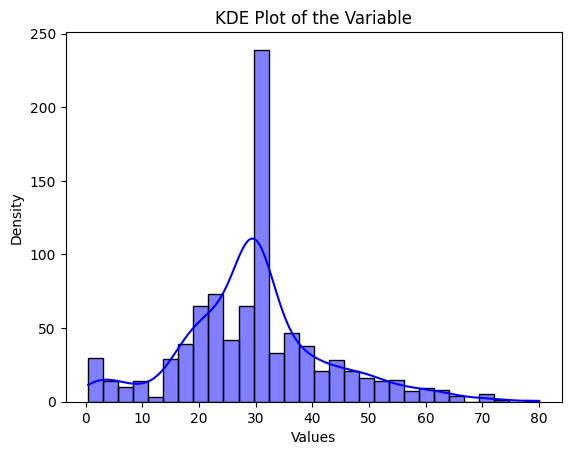

In [34]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
mean_age = df['Age'].mean()
df['Age']=df['Age'].fillna(mean_age)
print(df['Age'].mean())
print(df['Age'].std())
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('KDE Plot of the Variable')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

29.11242424242424
13.304424074688162


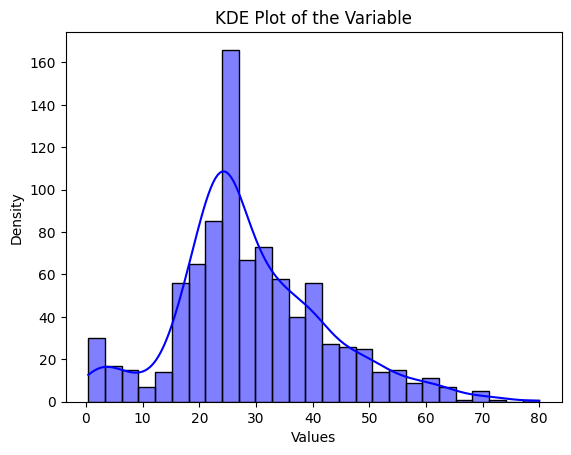

In [35]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
median_age_by_group = df.groupby(['Pclass', 'Sex'])['Age'].transform('median')
df['Age']=df['Age'].fillna(median_age_by_group)
print(df['Age'].mean())
print(df['Age'].std())
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('KDE Plot of the Variable')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

29.06640852974186
13.24453184208721


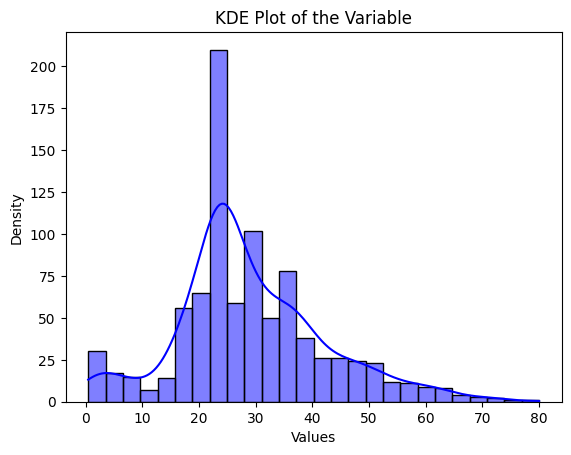

In [36]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
median_age_by_group = df.groupby(['Pclass'])['Age'].transform('median')
df['Age']=df['Age'].fillna(median_age_by_group)
print(df['Age'].mean())
print(df['Age'].std())
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('KDE Plot of the Variable')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

29.401664779161948
13.528075327085523


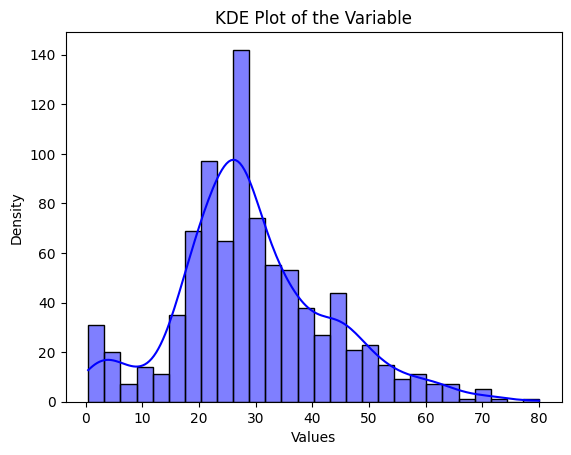

In [37]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
median_age_by_group = df.groupby(['Pclass', 'Sex','SibSp','Parch'])['Age'].transform('median')
df['Age']=df['Age'].fillna(median_age_by_group)
print(df['Age'].mean())
print(df['Age'].std())
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('KDE Plot of the Variable')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

29.401664779161948
13.528075327085523


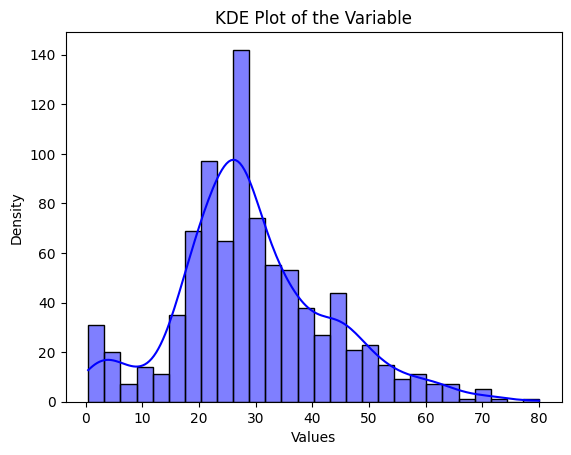

In [38]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
median_age_by_group = df.groupby(['Pclass', 'Sex','SibSp','Parch'])['Age'].transform('median')
df['Age']=df['Age'].fillna(median_age_by_group)
print(df['Age'].mean())
print(df['Age'].std())
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('KDE Plot of the Variable')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()